<a href="https://colab.research.google.com/github/tylerdn7/project-445/blob/master/EC_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle

!pip install numpy==1.15.0

!pip install catboost

    100% |████████████████████████████████| 13.9MB 2.1MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


    43% |██████████████                  | 24.3MB 41.8MB/s eta 0:00:01

In [0]:
import pandas as pd

import numpy as np

from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.svm import NuSVR, SVR

import matplotlib.pyplot as plt

import io

ModuleNotFoundError: ignored

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [0]:
!kaggle competitions list

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.9MB/s]
100% 242M/242M [00:01<00:00, 152MB/s]

100% 2.02G/2.03G [00:38<00:00, 96.6MB/s]
100% 2.03G/2.03G [00:38<00:00, 56.7MB/s]


In [0]:
!ls
!unzip train.csv.zip
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
import seaborn as sns
USAhousing = pd.read_csv('train.csv',skipfooter = 1000000,encoding="ISO=8859-1", engine = 'python')
USAhousing.head()
USAhousing.info()
USAhousing.describe()
USAhousing.columns



NameError: ignored

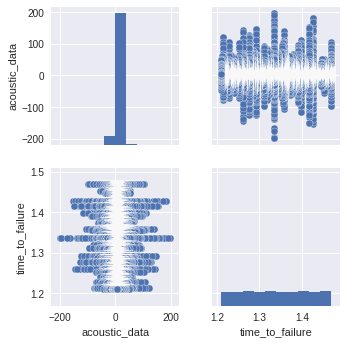

In [0]:
sns.pairplot(USAhousing)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


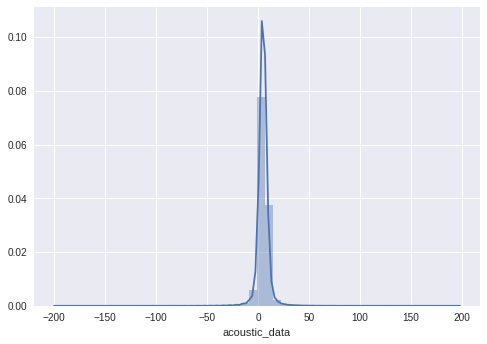

In [0]:
sns.distplot(USAhousing['acoustic_data'])

In [0]:
USAhousing.corr()

,acoustic_data,time_to_failure
acoustic_data,1.000000,-0.004695
time_to_failure,-0.004695,1.000000


In [0]:
X = pd.factorize(USAhousing['acoustic_data'].values)[0].reshape(-1, 1)
y = pd.factorize(USAhousing['time_to_failure'].values)[0].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=101)

In [0]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

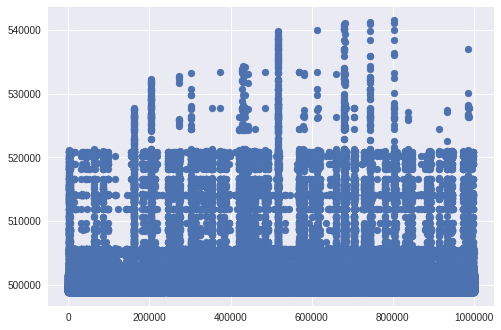

In [0]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(X_test,predictions)

500161.8341656588

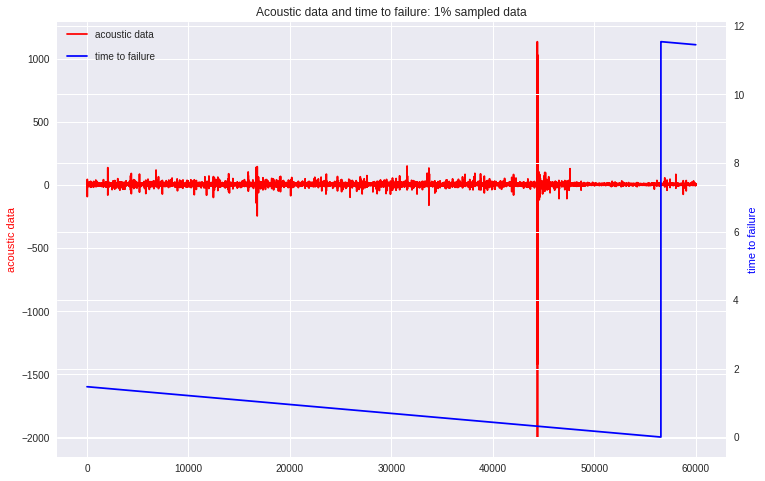

In [0]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


In [0]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [0]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7804224713035586}}

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}
